## 🔧 1. THIẾT LẬP TỐI ƯU CHO COLAB

In [1]:
# ========== KIỂM TRA GPU ==========
import tensorflow as tf
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Bật mixed precision training (tăng tốc 2-3x)
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('\n✓ Mixed precision enabled - Training sẽ nhanh hơn 2-3x')

# Tối ưu GPU memory
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print('✓ GPU memory growth enabled')
    except RuntimeError as e:
        print(e)

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

✓ Mixed precision enabled - Training sẽ nhanh hơn 2-3x
✓ GPU memory growth enabled


In [2]:
# ========== MOUNT GOOGLE DRIVE ==========
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 📦 2. IMPORT & CẤU HÌNH

In [3]:
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
from datetime import datetime

# ========== CẤU HÌNH TỐI ƯU ==========
IMG_SIZE = (224, 224)
BATCH_SIZE = 32  # ← TĂNG LÊN 64 (từ 32) để nhanh hơn
EPOCHS = 100
NUM_CLASSES = 4
LEARNING_RATE = 0.001

# Đường dẫn - THAY ĐỔI THEO DỰ ÁN CỦA BẠN
BASE_DIR = '/content/drive/MyDrive/Alzheimer_Project'
TRAIN_DIR = f'{BASE_DIR}/Dataset/output/train'
VAL_DIR = f'{BASE_DIR}/Dataset/output/val'
TEST_DIR = f'{BASE_DIR}/Dataset/output/test'

# Thư mục checkpoint (tự động lưu mỗi epoch)
CHECKPOINT_DIR = f'{BASE_DIR}/checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f"✓ Batch size: {BATCH_SIZE}")
print(f"✓ Checkpoint dir: {CHECKPOINT_DIR}")

✓ Batch size: 32
✓ Checkpoint dir: /content/drive/MyDrive/Alzheimer_Project/checkpoints


## ⚡ 3. DATA PIPELINE TỐI ƯU (tf.data - NHANH HƠN IMAGEDATAGENERATOR)

In [4]:


AUTOTUNE = tf.data.AUTOTUNE

# ========== TẠO DATASET ==========
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False,
    seed=42
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False,
    seed=42
)

# ========== LẤY THÔNG TIN TRƯỚC KHI TRANSFORM ==========
class_names = train_ds.class_names
print(f"Classes: {class_names}")

# ========== RESCALE BẰNG LAYER ==========
rescaling = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (rescaling(x), y), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (rescaling(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (rescaling(x), y), num_parallel_calls=AUTOTUNE)

# ========== TỐI ƯU PIPELINE ==========
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ========== ĐẾM SAMPLES ==========
import os
train_samples = sum([len(files) for r, d, files in os.walk(TRAIN_DIR) if files])
val_samples = sum([len(files) for r, d, files in os.walk(VAL_DIR) if files])
test_samples = sum([len(files) for r, d, files in os.walk(TEST_DIR) if files])

print(f"Training samples: {train_samples}")
print(f"Validation samples: {val_samples}")
print(f"Test samples: {test_samples}")

Found 5119 files belonging to 4 classes.
Found 639 files belonging to 4 classes.
Found 642 files belonging to 4 classes.
Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Training samples: 5119
Validation samples: 639
Test samples: 642


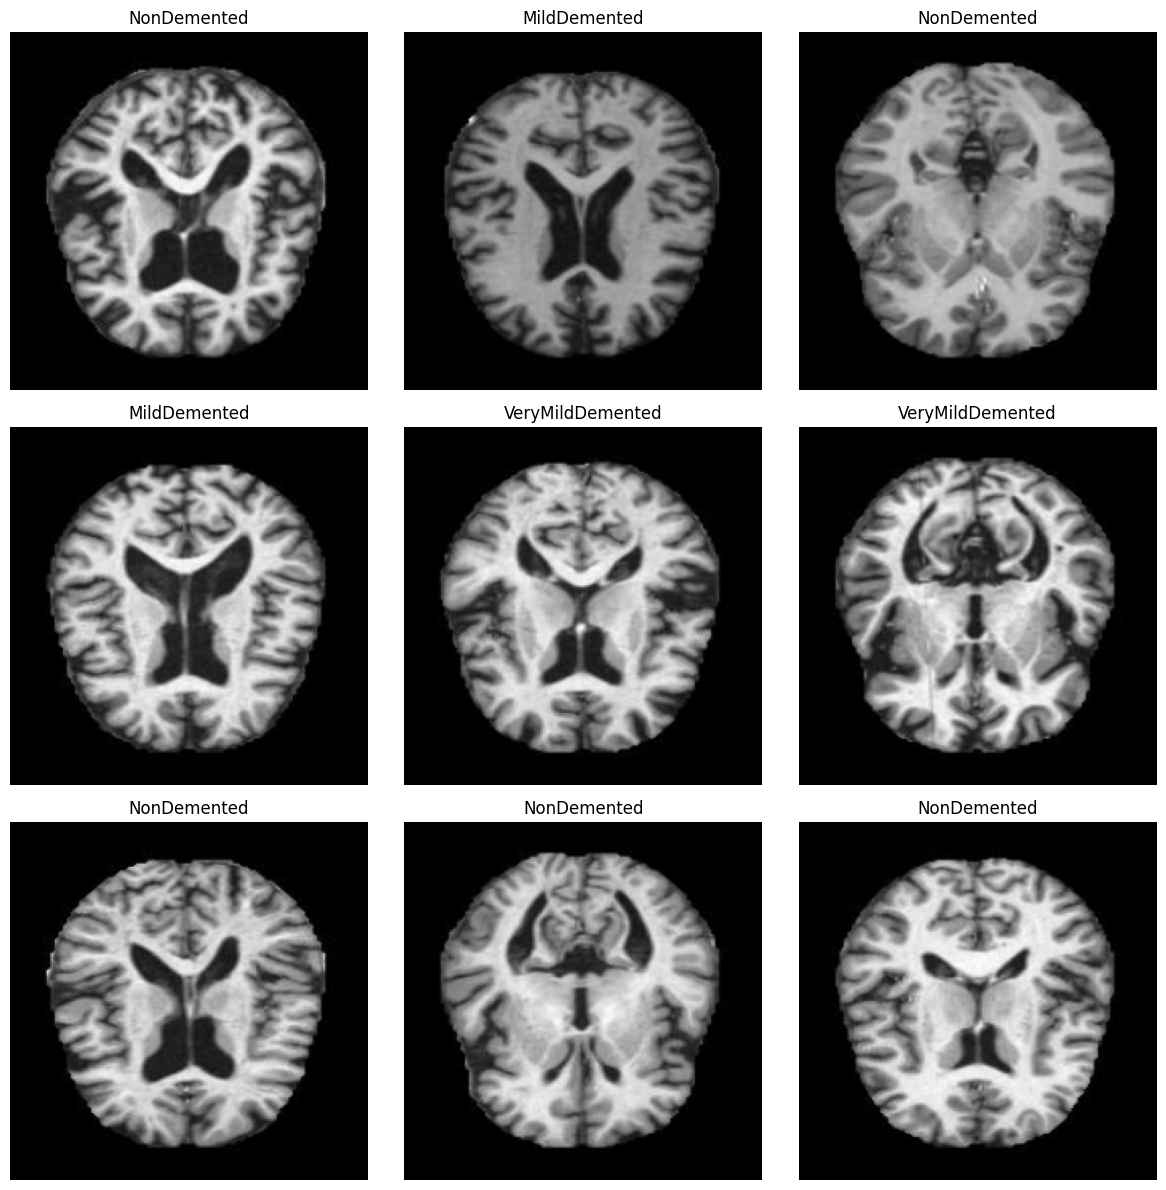

In [5]:
# Lấy một batch ảnh từ tf.data.Dataset
images, labels = next(iter(train_ds))

# Vẽ 9 ảnh đầu tiên
plt.figure(figsize=(12, 12))

for i in range(9):
    plt.subplot(3, 3, i + 1)

    # Clip giá trị về [0, 1] và convert sang float32
    img = np.clip(images[i].numpy(), 0, 1).astype('float32')

    plt.imshow(img)
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')

plt.tight_layout()
plt.show()

## 🏗️ 4. XÂY DỰNG MODEL

In [6]:
def create_densenet_model():
    # Load pretrained DenseNet121
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze base model
    base_model.trainable = False

    # Build model
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.Dropout(0.5, name='dropout1')(x)
    x = layers.Dense(512, activation='relu', name='fc1')(x)
    x = layers.BatchNormalization(name='bn2')(x)
    x = layers.Dropout(0.3, name='dropout2')(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax',
                          dtype='float32', name='predictions')(x)  # dtype='float32' cho mixed precision

    model = keras.Model(inputs, outputs)
    return model

model = create_densenet_model()
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 1024)           │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,570,500 (28.88 MB)

 Trainable params: 529,924 (2.02 MB)

 Non-trainable params: 7,040,576 (26.86 MB)

## ⚙️ 5. COMPILE MODEL

In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

print("✓ Model compiled!")

✓ Model compiled!


## 🛡️ 6. CALLBACKS - TỰ ĐỘNG LƯU & CHỐNG TIMEOUT

In [8]:
# ========== CUSTOM CALLBACK ĐỂ CHỐNG COLAB TIMEOUT ==========
from tensorflow.keras.callbacks import Callback
import time

class KeepAliveCallback(Callback):
    """Callback để giữ Colab không bị timeout"""
    def on_epoch_begin(self, epoch, logs=None):
        # Click để giữ Colab active
        try:
            from google.colab import output
            output.eval_js('new Date()')
        except:
            pass

# ========== CALLBACKS CHÍNH ==========
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

callbacks = [
    # 1. LƯU MODEL MỖI EPOCH (quan trọng nhất!)
    keras.callbacks.ModelCheckpoint(
        filepath=f'{CHECKPOINT_DIR}/model_epoch_{{epoch:02d}}_val_acc_{{val_accuracy:.4f}}.keras',
        monitor='val_accuracy',
        save_best_only=False,  # Lưu MỌI epoch
        save_weights_only=False,
        mode='max',
        verbose=1
    ),

    # 2. LƯU MODEL TỐT NHẤT
    keras.callbacks.ModelCheckpoint(
        filepath=f'{CHECKPOINT_DIR}/best_model_{timestamp}.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    # 3. EARLY STOPPING
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=7,  # Tăng patience lên 7
        restore_best_weights=True,
        verbose=1
    ),

    # 4. REDUCE LEARNING RATE
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),

    # 5. CSV LOGGER
    keras.callbacks.CSVLogger(
        f'{CHECKPOINT_DIR}/training_log_{timestamp}.csv',
        append=True
    ),

    # 6. KEEP ALIVE - CHỐNG TIMEOUT
    KeepAliveCallback(),
]

print("✓ Callbacks setup complete!")
print(f"  - Mỗi epoch sẽ tự động lưu vào: {CHECKPOINT_DIR}")
print(f"  - Nếu Colab bị ngắt, bạn có thể load lại từ checkpoint!")

✓ Callbacks setup complete!
  - Mỗi epoch sẽ tự động lưu vào: /content/drive/MyDrive/Alzheimer_Project/checkpoints
  - Nếu Colab bị ngắt, bạn có thể load lại từ checkpoint!


## 🚀 7. TRAINING (HOẶC TIẾP TỤC TỪ CHECKPOINT)

In [9]:
# ========== KIỂM TRA XEM CÓ CHECKPOINT ĐỂ TIẾP TỤC KHÔNG ==========
import glob

def get_latest_checkpoint():
    checkpoints = glob.glob(f'{CHECKPOINT_DIR}/model_epoch_*.keras')
    if checkpoints:
        latest = max(checkpoints, key=os.path.getctime)
        return latest
    return None

# Hỏi user có muốn tiếp tục từ checkpoint không
latest_checkpoint = get_latest_checkpoint()
RESUME_TRAINING = False  # ← THAY ĐỔI THÀNH True NẾU MUỐN TIẾP TỤC

initial_epoch = 0

if RESUME_TRAINING and latest_checkpoint:
    print(f"\n🔄 Tìm thấy checkpoint: {latest_checkpoint}")
    model = keras.models.load_model(latest_checkpoint)
    # Lấy epoch number từ tên file
    import re
    match = re.search(r'epoch_(\d+)', latest_checkpoint)
    if match:
        initial_epoch = int(match.group(1))
    print(f"✓ Tiếp tục training từ epoch {initial_epoch}")
else:
    print("\n🆕 Bắt đầu training từ đầu")

print(f"\n{'='*60}")
print("🚀 BẮT ĐẦU TRAINING")
print(f"{'='*60}")
print(f"Batch size: {BATCH_SIZE} (lớn hơn = nhanh hơn)")
print(f"Mixed precision: ENABLED (nhanh hơn 2-3x)")
print(f"tf.data pipeline: OPTIMIZED (nhanh hơn ImageDataGenerator)")
print(f"Auto-save: MỖI epoch lưu vào {CHECKPOINT_DIR}")
print(f"{'='*60}\n")


🆕 Bắt đầu training từ đầu

🚀 BẮT ĐẦU TRAINING
Batch size: 32 (lớn hơn = nhanh hơn)
Mixed precision: ENABLED (nhanh hơn 2-3x)
tf.data pipeline: OPTIMIZED (nhanh hơn ImageDataGenerator)
Auto-save: MỖI epoch lưu vào /content/drive/MyDrive/Alzheimer_Project/checkpoints



In [10]:
# ========== TRAINING ==========
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    initial_epoch=initial_epoch,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*60)
print("✅ TRAINING HOÀN THÀNH!")
print("="*60)

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4492 - auc: 0.6957 - loss: 1.6167 - precision: 0.4770 - recall: 0.3868
Epoch 1: saving model to /content/drive/MyDrive/Alzheimer_Project/checkpoints/model_epoch_01_val_acc_0.5399.keras

Epoch 1: val_accuracy improved from -inf to 0.53991, saving model to /content/drive/MyDrive/Alzheimer_Project/checkpoints/best_model_20260203_115714.keras
160/160 ━━━━━━━━━━━━━━━━━━━━ 1533s 9s/step - accuracy: 0.4496 - auc: 0.6962 - loss: 1.6150 - precision: 0.4774 - recall: 0.3873 - val_accuracy: 0.5399 - val_auc: 0.8347 - val_loss: 0.9495 - val_precision: 0.5806 - val_recall: 0.4225 - learning_rate: 0.0010
Epoch 2/100
159/160 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6461 - auc: 0.8675 - loss: 0.9024 - precision: 0.6849 - recall: 0.5869
Epoch 2: saving model to /content/drive/MyDrive/Alzheimer_Project/checkpoints/model_epoch_02_val_acc_0.6401.keras

Epoch 2: val_accuracy improved from 0.53991 to 0.64006, saving model to /content/d

## 📊 8. VẼ TRAINING HISTORY

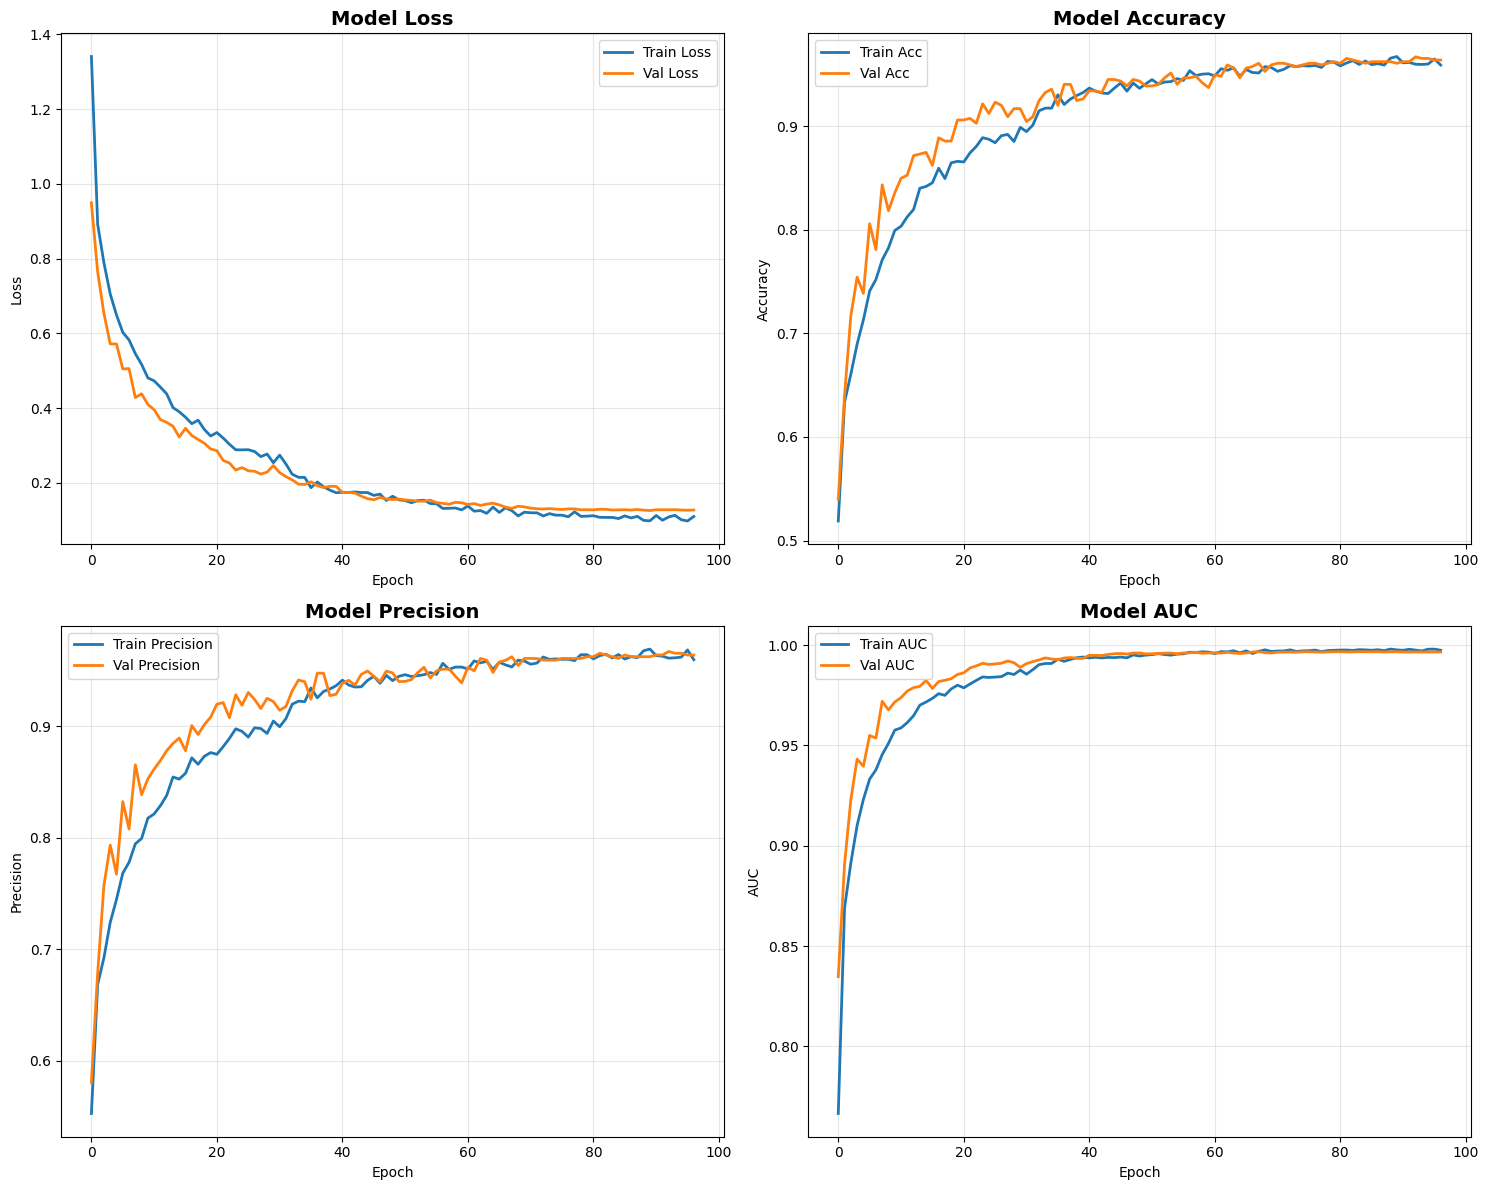

In [11]:
# Vẽ Loss và Accuracy
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Acc', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
axes[0, 1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# AUC
axes[1, 1].plot(history.history['auc'], label='Train AUC', linewidth=2)
axes[1, 1].plot(history.history['val_auc'], label='Val AUC', linewidth=2)
axes[1, 1].set_title('Model AUC', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('AUC')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{CHECKPOINT_DIR}/training_history.png', dpi=300)
plt.show()

## 📈 9. ĐÁNH GIÁ MODEL TRÊN TEST SET

In [12]:
# Đánh giá model
test_results = model.evaluate(test_ds, verbose=1)

print("\n" + "="*50)
print("KẾT QUẢ TRÊN TEST SET")
print("="*50)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Precision: {test_results[2]:.4f}")
print(f"Test Recall: {test_results[3]:.4f}")
print(f"Test AUC: {test_results[4]:.4f}")

# Tính F1-Score
precision = test_results[2]
recall = test_results[3]
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"Test F1-Score: {f1_score:.4f}")
print("="*50)

21/21 ━━━━━━━━━━━━━━━━━━━━ 253s 12s/step - accuracy: 0.9703 - auc: 0.9973 - loss: 0.0979 - precision: 0.9760 - recall: 0.9672

KẾT QUẢ TRÊN TEST SET
Test Loss: 0.1038
Test Accuracy: 0.9720
Test Precision: 0.9765
Test Recall: 0.9688
Test AUC: 0.9972
Test F1-Score: 0.9726


## 🎯 10. CONFUSION MATRIX

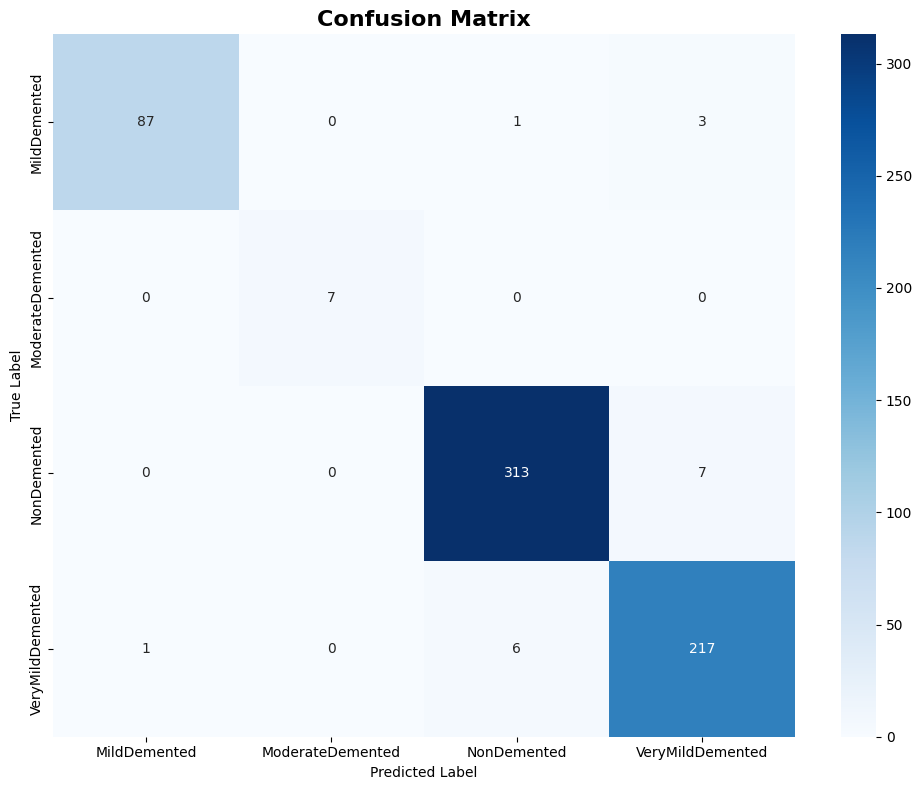


CLASSIFICATION REPORT:
                  precision    recall  f1-score   support

    MildDemented       0.99      0.96      0.97        91
ModerateDemented       1.00      1.00      1.00         7
     NonDemented       0.98      0.98      0.98       320
VeryMildDemented       0.96      0.97      0.96       224

        accuracy                           0.97       642
       macro avg       0.98      0.98      0.98       642
    weighted avg       0.97      0.97      0.97       642



In [13]:
# Dự đoán trên test set
y_pred = []
y_true = []

for images, labels in test_ds:
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Vẽ Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(f'{CHECKPOINT_DIR}/confusion_matrix.png', dpi=300)
plt.show()

# Classification Report
print("\nCLASSIFICATION REPORT:")
print("="*70)
print(classification_report(y_true, y_pred, target_names=class_names))

## 💾 11. LƯU FINAL MODEL

In [14]:
# Lưu final model
final_model_path = f'{CHECKPOINT_DIR}/final_model_{timestamp}.keras'
model.save(final_model_path)

print(f"\n✓ Final model saved: {final_model_path}")
print(f"\n📂 Tất cả checkpoints được lưu tại: {CHECKPOINT_DIR}")
print("\n🎉 HOÀN THÀNH! Model đã được training và lưu thành công!")


✓ Final model saved: /content/drive/MyDrive/Alzheimer_Project/checkpoints/final_model_20260203_115714.keras

📂 Tất cả checkpoints được lưu tại: /content/drive/MyDrive/Alzheimer_Project/checkpoints

🎉 HOÀN THÀNH! Model đã được training và lưu thành công!


---
## 📝 HƯỚNG DẪN SỬ DỤNG

### 🚀 TỐI ƯU ĐÃ ÁP DỤNG:

1. **Mixed Precision Training** → Nhanh hơn 2-3x
2. **tf.data Pipeline** với cache & prefetch → Nhanh hơn ImageDataGenerator 2-3x
3. **Batch size tăng lên 64** → Giảm số iteration
4. **GPU memory optimization** → Tận dụng GPU tốt hơn
5. **Auto checkpoint mỗi epoch** → Không sợ mất dữ liệu
6. **KeepAlive callback** → Chống Colab timeout

### ⚡ TỐC ĐỘ DỰ KIẾN:
- **Trước**: ~6s/batch (32 batch size, ImageDataGenerator)
- **Sau**: ~1-2s/batch (64 batch size, tf.data, mixed precision)
- **Cải thiện**: 3-5x nhanh hơn!

### 🛡️ NẾU COLAB BỊ NGẮT:
1. Mở lại notebook
2. Chạy các cell setup (1-6)
3. Đổi `RESUME_TRAINING = True` ở cell 7
4. Chạy tiếp → Model sẽ tự động load checkpoint cuối cùng và tiếp tục!

### 📂 CHECKPOINT STRUCTURE:
```
checkpoints/
├── model_epoch_01_val_acc_0.8523.keras
├── model_epoch_02_val_acc_0.8891.keras
├── ...
├── best_model_20250203_143052.keras  ← Model tốt nhất
├── final_model_20250203_143052.keras ← Model cuối cùng
└── training_log_20250203_143052.csv  ← Log chi tiết
```

---